In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns 
import os

# =========================================================
# ⚙️ KONFIGURASI
# =========================================================
FOLDER_DATA = "/work/open_meteo_climate"
NAMA_FILE = "kebumen_75tahun_lengkap.csv" 
PATH_FILE = os.path.join(FOLDER_DATA, NAMA_FILE)

In [25]:
# =========================================================
# 1. LOAD DATA (MEMUAT DATA)
# =========================================================
def load_data(filepath):
    print(f"📂 Mencoba membuka file: {filepath}")
    if not os.path.exists(filepath):
        print(f"❌ File tidak ditemukan di path tersebut.")
        return None
    
    try:
        # 1. Baca CSV
        df = pd.read_csv(filepath, index_col='date')
        
        # 2. KONVERSI PAKSA KE DATETIME
        df.index = pd.to_datetime(df.index, utc=True, errors='coerce')
        
        # 3. Konversi ke WIB (Asia/Jakarta)
        df.index = df.index.tz_convert('Asia/Jakarta')
        
        # 4. HAPUS INFO ZONA WAKTU (Timezone-Naive)
        df.index = df.index.tz_localize(None)
        
        # 5. Urutkan Index
        df = df.sort_index()
        
        print(f"✅ Data berhasil dimuat & dikonversi! Total: {len(df)} baris.")
        print(f"   Rentang: {df.index.min()} s.d {df.index.max()}")
        return df
        
    except Exception as e:
        print(f"❌ Gagal memproses data: {e}")
        return None

# =========================================================
# 2. STATISTIK DASAR (DESCRIPTIVE)
# =========================================================
def show_basic_stats(df):
    print("\n--- 📊 STATISTIK DASAR ---")
    stats = df[['temperature', 'rain_mm']].describe().T 
    print(stats[['mean', 'min', 'max', 'std']])
    
    total_hujan = df['rain_mm'].sum()
    print(f"\n🌧️ Total Curah Hujan (Seluruh Dataset): {total_hujan:.2f} mm")

# =========================================================
# 3. FUNGSI ANALISIS DETAIL (TABEL & ANGKA)
# =========================================================
def analisis_detail(df, target_waktu):
    """
    Menampilkan statistik mendalam: Suhu Ekstrem, Hari Hujan, dll.
    """
    print(f"\n🔎 ANALISIS DETAIL PERIODE: {target_waktu}")
    print("="*50)
    
    try:
        # Slicing Data
        subset = df.loc[target_waktu]
        if subset.empty:
            print("⚠️ Data tidak ditemukan.")
            return

        # --- A. ANALISIS SUHU ---
        print("🌡️ STATISTIK SUHU")
        # Cari Max & Min
        max_temp = subset['temperature'].max()
        max_temp_date = subset['temperature'].idxmax()
        
        min_temp = subset['temperature'].min()
        min_temp_date = subset['temperature'].idxmin()
        
        print(f"   🔥 Suhu Maksimum  : {max_temp:.2f}°C (pada {max_temp_date})")
        print(f"   ❄️ Suhu Minimum : {min_temp:.2f}°C (pada {min_temp_date})")
        print("-" * 30)

        # --- B. ANALISIS HUJAN ---
        print("🌧️ STATISTIK HUJAN")
        
        # Agregasi Harian dulu biar analisisnya per HARI (bukan per jam)
        harian = subset['rain_mm'].resample('D').sum()
        
        # 1. Total Hujan
        total_hujan = harian.sum()
        print(f"   🌊 Total Curah Hujan : {total_hujan:.2f} mm")
        
        # 2. Hujan Paling Lebat Sehari
        max_hujan_sehari = harian.max()
        tgl_max_hujan = harian.idxmax().strftime('%Y-%m-%d')
        print(f"   ⛈️ Hujan Terlebat   : {max_hujan_sehari:.2f} mm (Tgl {tgl_max_hujan})")
        
        # 3. Hari Hujan > 10 mm (Lebat)
        hari_basah = harian[harian > 10]
        jml_hari_basah = len(hari_basah)
        print(f"   ☔ Hari Basah (>10mm): {jml_hari_basah} hari")
        
        # 4. Hari Hujan < 10 mm (Ringan/Gerimis)
        # Kita hitung yang hujan (>0) tapi kurang dari 10
        hari_gerimis = harian[(harian > 0) & (harian <= 10)]
        jml_hari_gerimis = len(hari_gerimis)
        print(f"   ☁️ Hari Kering (<=10mm): {jml_hari_gerimis} hari")
    
        
        print("="*50)

    except KeyError:
        print(f"❌ Format waktu salah. Gunakan 'YYYY' atau 'YYYY-MM'.")
    except Exception as e:
        print(f"⚠️ Error analisis: {e}")

# =========================================================
# 4. FUNGSI PLOTTING (GRAFIK)
# =========================================================
def plot_periode_tertentu(df, target_waktu):
    print(f"\n🎨 Menggambar grafik untuk periode: {target_waktu}...")
    
    try:
        subset = df.loc[target_waktu]
        if subset.empty: return

        fig, ax1 = plt.subplots(figsize=(12, 6))
        
        # Plot Suhu
        ax1.plot(subset.index, subset['temperature'], 
                 color='darkorange', marker='', linestyle='-', linewidth=1.5, label='Suhu (°C)')
        ax1.set_ylabel('Suhu (°C)', color='darkorange', fontweight='bold')
        ax1.tick_params(axis='y', labelcolor='darkorange')
        ax1.grid(True, linestyle='--', alpha=0.5)
        
        # Plot Hujan
        ax2 = ax1.twinx()
        width = 0.04 if len(str(target_waktu)) > 7 else 0.5 
        ax2.bar(subset.index, subset['rain_mm'], 
                color='dodgerblue', alpha=0.4, width=width, label='Hujan (mm)')
        ax2.set_ylabel('Hujan (mm)', color='dodgerblue', fontweight='bold')
        ax2.tick_params(axis='y', labelcolor='dodgerblue')
        
        # Format Sumbu X
        if len(str(target_waktu)) > 7: # Harian
            ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
            ax1.set_xlabel('Jam (WIB)')
            judul = f"Cuaca Detail Tanggal: {target_waktu}"
        elif len(str(target_waktu)) == 7: # Bulanan
            ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
            ax1.set_xlabel('Tanggal')
            judul = f"Tren Cuaca Bulan: {target_waktu}"
        else: # Tahunan
            ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
            ax1.set_xlabel('Bulan')
            judul = f"Tren Cuaca Tahun: {target_waktu}"

        plt.title(judul, fontweight='bold', fontsize=14)
        
        # Gabung Legend
        lines_1, labels_1 = ax1.get_legend_handles_labels()
        lines_2, labels_2 = ax2.get_legend_handles_labels()
        ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"⚠️ Terjadi error saat plotting: {e}")

📂 Mencoba membuka file: /work/open_meteo_climate/kebumen_75tahun_lengkap.csv
✅ Data berhasil dimuat & dikonversi! Total: 665472 baris.
   Rentang: 1950-01-01 01:00:00 s.d 2025-11-30 23:00:00

🔎 ANALISIS DETAIL PERIODE: 2025-11
🌡️ STATISTIK SUHU
   🔥 Suhu Maksimum  : 30.39°C (pada 2025-11-10 13:00:00)
   ❄️ Suhu Minimum : 22.89°C (pada 2025-11-29 05:00:00)
------------------------------
🌧️ STATISTIK HUJAN
   🌊 Total Curah Hujan : 460.00 mm
   ⛈️ Hujan Terlebat   : 70.20 mm (Tgl 2025-11-19)
   ☔ Hari Basah (>10mm): 16 hari
   ☁️ Hari Kering (<=10mm): 14 hari

🎨 Menggambar grafik untuk periode: 2025-11...


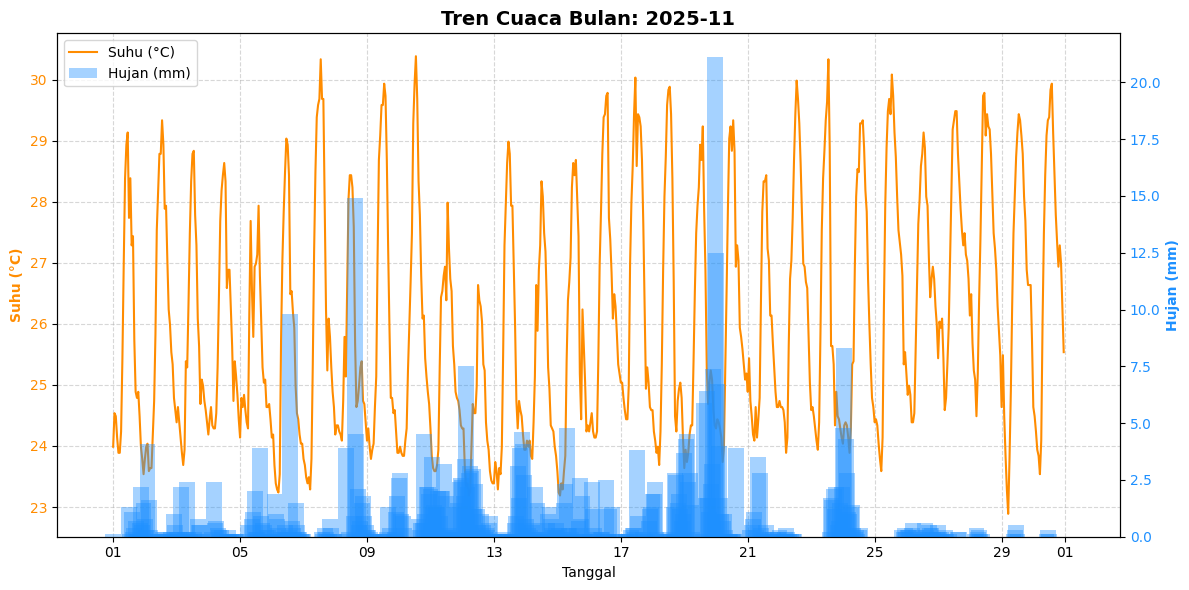

In [28]:
# =========================================================
# EKSEKUSI UTAMA
# =========================================================
if __name__ == "__main__":
    df_cuaca = load_data(PATH_FILE)
    
    if df_cuaca is not None:
        # Contoh Analisis Bulan Oktober 2022 (Bulan Basah)
        TARGET = "2025-11"
        
        # 1. Tampilkan Angka Statistik
        analisis_detail(df_cuaca, TARGET)
        
        # 2. Tampilkan Grafik
        plot_periode_tertentu(df_cuaca, TARGET)

In [31]:
df_cuaca.tail(10)

,temperature,humidity,dewpoint,rain_mm,wind_speed,wind_direction,pressure,weather_code
date,,,,,,,,
2025-11-30 14:00:00,29.938000,63.414394,22.237999,0.0,12.043869,170.537750,1007.04160,2.0
2025-11-30 15:00:00,29.138000,66.004585,22.138000,0.0,12.072083,159.943820,1007.23520,3.0
2025-11-30 16:00:00,28.487999,69.378240,22.338000,0.0,11.133840,145.539120,1007.33057,3.0
2025-11-30 17:00:00,27.788000,73.149430,22.538000,0.0,9.600937,149.589000,1007.82446,3.0
2025-11-30 18:00:00,27.338000,73.967865,22.288000,0.0,7.388775,145.922760,1008.81885,3.0
2025-11-30 19:00:00,26.938000,79.490326,23.088000,0.0,1.297998,123.690094,1009.71405,3.0
2025-11-30 20:00:00,27.288000,80.260460,23.588000,0.0,1.451206,97.124920,1010.41500,3.0
2025-11-30 21:00:00,26.987999,83.174270,23.888000,0.0,1.484318,75.963730,1010.81200,3.0
2025-11-30 22:00:00,26.237999,85.633550,23.638000,0.0,1.609969,63.435013,1010.60700,1.0


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=672c3bf7-b636-46e8-b7c0-4f6feec29313' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>